In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import re
import matplotlib.pyplot as plt

### Load the excluded ingredients and two metadata files. Concatenate the metadata files into one. 

In [2]:
# Read the list of excluded ingredients
with open('excluded_ingredients.txt', 'r') as f:
    excluded_ingredients = set(line.strip() for line in f)

# Function to read metadata CSV files without headers and assign column names
def read_metadata(csv_file):
    # Read without headers
    metadata = pd.read_csv(csv_file, header=None, low_memory=False)
    num_cols = metadata.shape[1]
    
    # Define base columns and ingredient columns
    base_columns = ['dish_id', 'total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']
    ingredient_columns = ['ingr_{n}_id', 'ingr_{n}_name', 'ingr_{n}_grams', 'ingr_{n}_calories', 'ingr_{n}_fat', 'ingr_{n}_carb', 'ingr_{n}_protein']
    
    len_base = len(base_columns)
    len_ingr = len(ingredient_columns)
    max_n = (num_cols - len_base) // len_ingr
    
    # Generate column names
    columns = base_columns.copy()
    for n in range(1, max_n + 1):
        columns += [col.format(n=n) for col in ingredient_columns]
    
    # Check if total columns match
    if len(columns) != num_cols:
        print(f"Warning: Number of columns does not match for {csv_file}")
        # Optionally, handle or raise an error here
    
    metadata.columns = columns
    return metadata

# Read the metadata CSV files
metadata_cafe1 = read_metadata('nutrition5k_dataset/metadata/dish_metadata_cafe1.csv')
metadata_cafe2 = read_metadata('nutrition5k_dataset/metadata/dish_metadata_cafe2.csv')

# Concatenate the dataframes
metadata = pd.concat([metadata_cafe1, metadata_cafe2], ignore_index=True)
metadata.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,ingr_1_id,ingr_1_name,ingr_1_grams,ingr_1_calories,...,ingr_33_fat,ingr_33_carb,ingr_33_protein,ingr_34_id,ingr_34_name,ingr_34_grams,ingr_34_calories,ingr_34_fat,ingr_34_carb,ingr_34_protein
0,dish_1561662216,300.794281,193,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.801241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dish_1562688426,137.569992,88,8.256000,5.190000,10.297000,ingr_0000000433,roasted potatoes,17.000000,23.970000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dish_1561662054,419.438782,292,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dish_1562008979,382.936646,290,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dish_1560455030,20.590000,103,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create a sorted list of ingredients. Make sure that excluded ingredients are not in the list. (Some ingredients are excluded to overcome class imbalance and because the model is not likely to detect them, e.g. salt, pepper, wine, etc.)

In [3]:
# Extract ingredient indices from the column names
ingredient_indices = set()
for col in metadata.columns:
    m = re.match(r'ingr_(\d+)_name', col)
    if m:
        ingredient_indices.add(int(m.group(1)))
ingredient_indices = sorted(list(ingredient_indices))

# Construct a mapping from dish_id to ingredients (excluding excluded ingredients)
dish_ingredients = {}

for idx, row in metadata.iterrows():
    dish_id = row['dish_id']
    ingredients = []
    for n in ingredient_indices:
        ingr_name_col = f'ingr_{n}_name'
        if ingr_name_col in row and not pd.isna(row[ingr_name_col]):
            ingredient_name = str(row[ingr_name_col]).strip()
            if ingredient_name not in excluded_ingredients:
                ingredient = {
                    'name': ingredient_name,
                    'grams': row.get(f'ingr_{n}_grams', np.nan),
                    'calories': row.get(f'ingr_{n}_calories', np.nan),
                    'fat': row.get(f'ingr_{n}_fat', np.nan),
                    'carb': row.get(f'ingr_{n}_carb', np.nan),
                    'protein': row.get(f'ingr_{n}_protein', np.nan)
                }
                ingredients.append(ingredient)
    dish_ingredients[dish_id] = ingredients

# Create a list of all unique ingredients
all_ingredients_set = set()
for ingredients in dish_ingredients.values():
    for ingredient in ingredients:
        all_ingredients_set.add(ingredient['name'])

all_ingredients = sorted(list(all_ingredients_set))
ingredient_to_index = {ingredient: idx for idx, ingredient in enumerate(all_ingredients)}

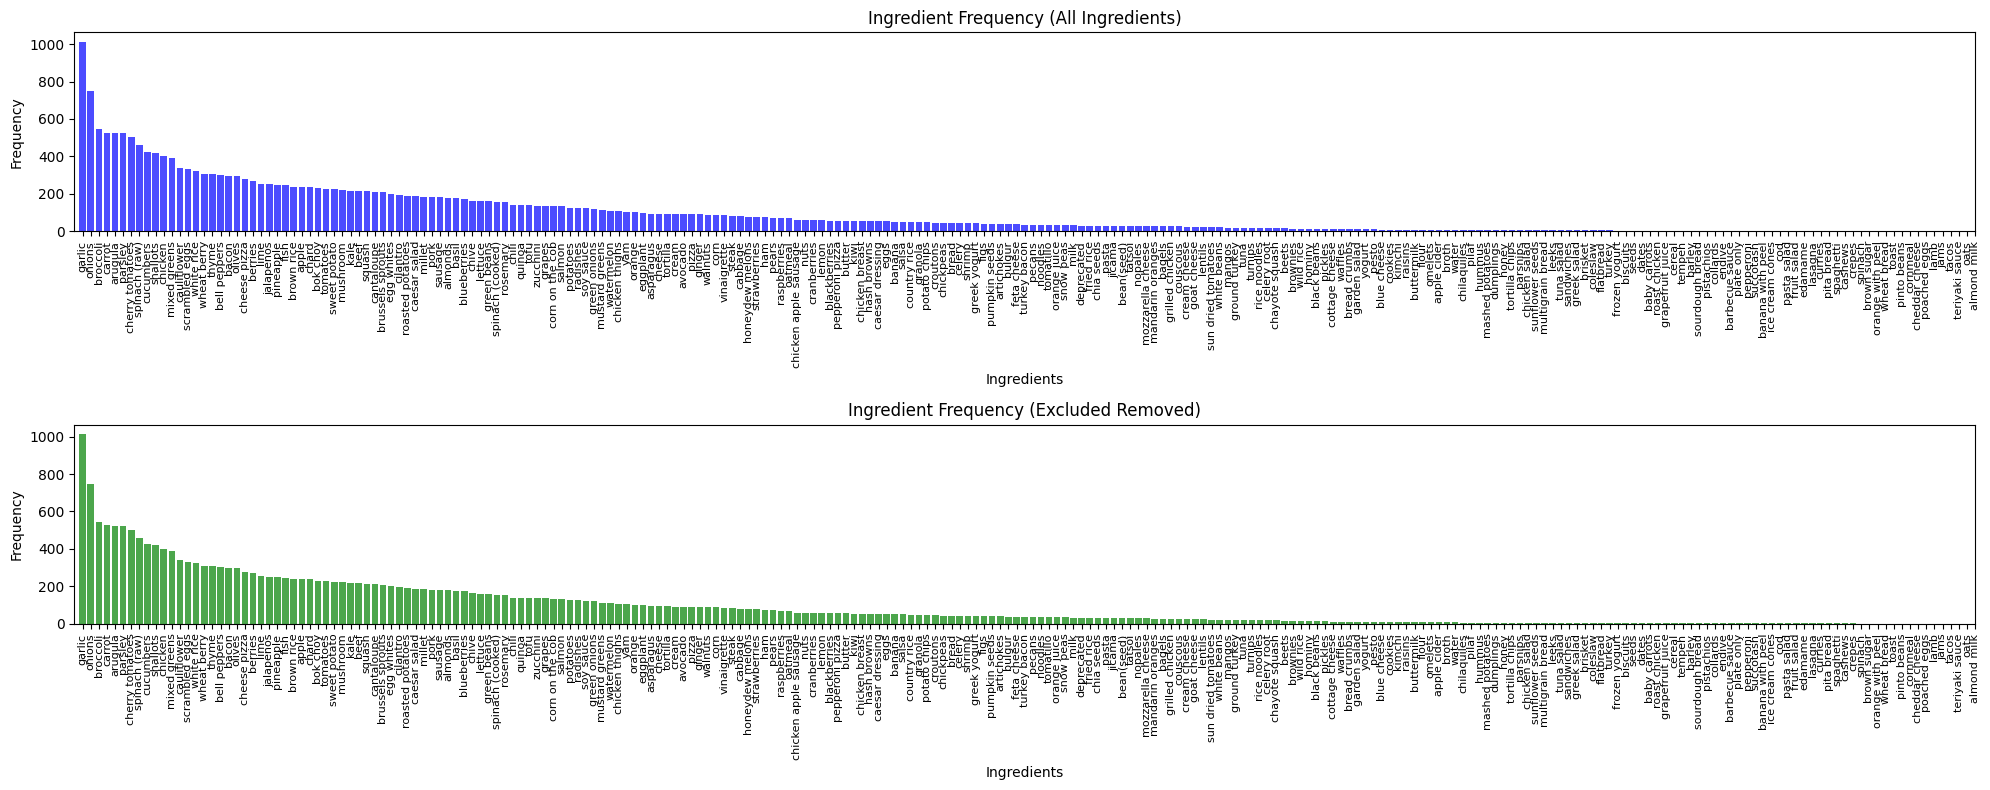

In [16]:
# Create ingredient frequency dictionaries
ingredient_counts_all = {}
ingredient_counts_filtered = {}

for ingredients in dish_ingredients.values():
    for ingredient in ingredients:
        # Count all ingredients
        ingredient_name = ingredient['name']
        ingredient_counts_all[ingredient_name] = ingredient_counts_all.get(ingredient_name, 0) + 1
        
        # Count after filtering excluded ingredients
        if ingredient_name not in excluded_ingredients:
            ingredient_counts_filtered[ingredient_name] = ingredient_counts_filtered.get(ingredient_name, 0) + 1

# Sort ingredients by frequency (descending order)
sorted_ingredients_all = sorted(ingredient_counts_all.items(), key=lambda x: x[1], reverse=True)
sorted_ingredients_filtered = sorted(ingredient_counts_filtered.items(), key=lambda x: x[1], reverse=True)

# Extract data for plotting
ingredients_all, counts_all = zip(*sorted_ingredients_all)
ingredients_filtered, counts_filtered = zip(*sorted_ingredients_filtered)

# Plot histograms
plt.figure(figsize=(20, 8))

# Histogram for all ingredients
plt.subplot(2, 1, 1)
bars_all = plt.bar(ingredients_all, counts_all, color='blue', alpha=0.7)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Ingredients')
plt.ylabel('Frequency')
plt.title('Ingredient Frequency (All Ingredients)')
plt.xlim(-1, len(ingredients_all) - 1)  # Reduce whitespace on x-axis

# Histogram for filtered ingredients
plt.subplot(2, 1, 2)
bars_filtered = plt.bar(ingredients_filtered, counts_filtered, color='green', alpha=0.7)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Ingredients')
plt.ylabel('Frequency')
plt.title('Ingredient Frequency (Excluded Removed)')
plt.xlim(-1, len(ingredients_filtered) - 1)  # Reduce whitespace on x-axis

plt.tight_layout()  # Adjust layout to minimize empty space
plt.show()

### Only use metadata rows for which there is an image in the imagery/realsense_overhead folder.

In [17]:
# Prepare the dataset with image paths and labels
data = []

count=0
for dish_id, ingredients in dish_ingredients.items():
    image_path = f'nutrition5k_dataset/imagery/realsense_overhead/{dish_id}/rgb.png'
    if os.path.exists(image_path):
        # Create the multi-hot label vector
        label = np.zeros(len(all_ingredients), dtype=np.float32)
        for ingredient in ingredients:
            idx = ingredient_to_index[ingredient['name']]
            label[idx] = 1.0
        data.append({
            'dish_id': dish_id,
            'image_path': image_path,
            'label': label
        })
    else:
        count += 1
        # print(f'Warning: Image for {dish_id} not found at {image_path}')
        print(f"There are {count} dish_id that have no image at nutrition5k_dataset/imagery/realsense_overhead.", end="\r")

### Display two examples of binarized ingredients data.

In [18]:
data[:2]

[{'dish_id': 'dish_1561662216',
  'image_path': 'nutrition5k_dataset/imagery/realsense_overhead/dish_1561662216/rgb.png',
  'label': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0

### Define training and validation datasets.

In [6]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Prepare lists of image paths and labels
train_image_paths = [item['image_path'] for item in train_data]
train_labels = [item['label'] for item in train_data]

val_image_paths = [item['image_path'] for item in val_data]
val_labels = [item['label'] for item in val_data]

### Preprocess the images for MobileNetV3.  Create the training and validation datasets.

In [7]:
# Load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    return image, label

# Create TensorFlow datasets
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Create a custom F1-score for this model
A custom F1 score was used because the tf.keras function cannot be used as part of the metric panel. The F1 score is calculated at the very end of training, and to get the F1 score over the entire validation set, one could use micro-averaging (average="micro"). However, one additional advantage of having a custom F1 score function is that we can restrict the score over relevant classes, i.e. not counting classes for which there is no entry in either the true or predicted class.  This is a potential issue as we have excluded ingredients which would likely be invisible on the photographic images. Using this custom function allows us to report the F1 score at the end of each epoch over the entire validation dataset, by loading it into memory before training and comparing the predictions with all the true labels.

In [10]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Metric

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image.numpy()

# Validation dataset pointer has to be reset to the beginning. Load images into NumPy arrays once again. 
val_x = np.array([load_and_preprocess_image(path) for path in val_image_paths])
val_y = np.array(val_labels)     # Ensure val_labels is a NumPy array, too.


class F1Score(Metric):
    def __init__(self, num_classes, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.num_classes = num_classes  # Total number of classes
        
        # Initialize accumulators for true positives, false positives, false negatives
        self.tp = self.add_weight(name='tp', shape=(self.num_classes,), initializer='zeros')
        self.fp = self.add_weight(name='fp', shape=(self.num_classes,), initializer='zeros')
        self.fn = self.add_weight(name='fn', shape=(self.num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Binarize predictions using the threshold
        y_pred = tf.cast(y_pred >= self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        # Compute per-class true positives, false positives, false negatives
        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
        
        # Update accumulators
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)
            
    def result(self):
        # Compute precision and recall per class
        precision = tf.math.divide_no_nan(self.tp, self.tp + self.fp)
        recall = tf.math.divide_no_nan(self.tp, self.tp + self.fn)
        
        # Compute F1 score per class
        f1_per_class = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        
        # Identify relevant classes (classes with at least one true positive or predicted positive)
        relevant = (self.tp + self.fp + self.fn) > 0
        
        # Filter relevant classes
        f1_per_class = tf.boolean_mask(f1_per_class, relevant)
        supports = tf.boolean_mask(self.tp + self.fn, relevant)  # Number of true instances per class
        
        # Compute weighted average F1 score
        weighted_f1 = tf.math.divide_no_nan(tf.reduce_sum(f1_per_class * supports), tf.reduce_sum(supports))
        
        # Handle case when there are no relevant classes
        weighted_f1 = tf.where(tf.math.is_nan(weighted_f1), tf.zeros_like(weighted_f1), weighted_f1)
        
        return weighted_f1
    
    def reset_states(self):
        # Reset accumulators
        self.tp.assign(tf.zeros_like(self.tp))
        self.fp.assign(tf.zeros_like(self.fp))
        self.fn.assign(tf.zeros_like(self.fn))

# Determine the number of classes
class_names = all_ingredients
num_classes = len(class_names)

# Create an instance of the custom metric
f1_metric = F1Score(num_classes=num_classes, name='f1_score')

### Define the model, based on MobileNetV3Large. Set freezing layer for transfer learning. Define custom layers. Compile the model. Visualize total layers. 

In [27]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from sklearn.metrics import f1_score

# Load the pre-trained MobileNetV3 model without the top layers
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Specify freezing layer
for layer in base_model.layers[:90]:
    layer.trainable = False
for layer in base_model.layers[90:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(len(all_ingredients), activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        BinaryAccuracy(name='binary_accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc', multi_label=True),
        f1_metric
    ]
)

print(f"Model has {len(model.layers)} layers, of which {len(base_model.layers)} come from MobileNetV3")

Model has 192 layers, of which 187 come from MobileNetV3


### Set epoch number and start training the model.

In [28]:
# Instantiate the callback
#f1_callback = F1ScoreCallback(val_x, val_y)
epochs = 40

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 317ms/step - auc: 0.4425 - binary_accuracy: 0.8011 - f1_score: 0.2851 - loss: 0.4162 - precision: 0.0298 - recall: 0.2207 - val_auc: 0.5014 - val_binary_accuracy: 0.9781 - val_f1_score: 0.0118 - val_loss: 0.0886 - val_precision: 0.8276 - val_recall: 0.0067
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 317ms/step - auc: 0.5617 - binary_accuracy: 0.9762 - f1_score: 0.0433 - loss: 0.0854 - precision: 0.7687 - recall: 0.0348 - val_auc: 0.5657 - val_binary_accuracy: 0.9784 - val_f1_score: 0.0419 - val_loss: 0.0763 - val_precision: 0.8049 - val_recall: 0.0275
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 317ms/step - auc: 0.6347 - binary_accuracy: 0.9774 - f1_score: 0.1143 - loss: 0.0727 - precision: 0.7505 - recall: 0.0867 - val_auc: 0.5927 - val_binary_accuracy: 0.9790 - val_f1_score: 0.1194 - val_loss: 0.0708 - val_precision: 0.6937 - val_recall: 0.0857
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 315ms/step - auc: 0.6640 - binary_accuracy: 0.9787 - f1_score

### Plot loss, accuracy, AUC and F1 score

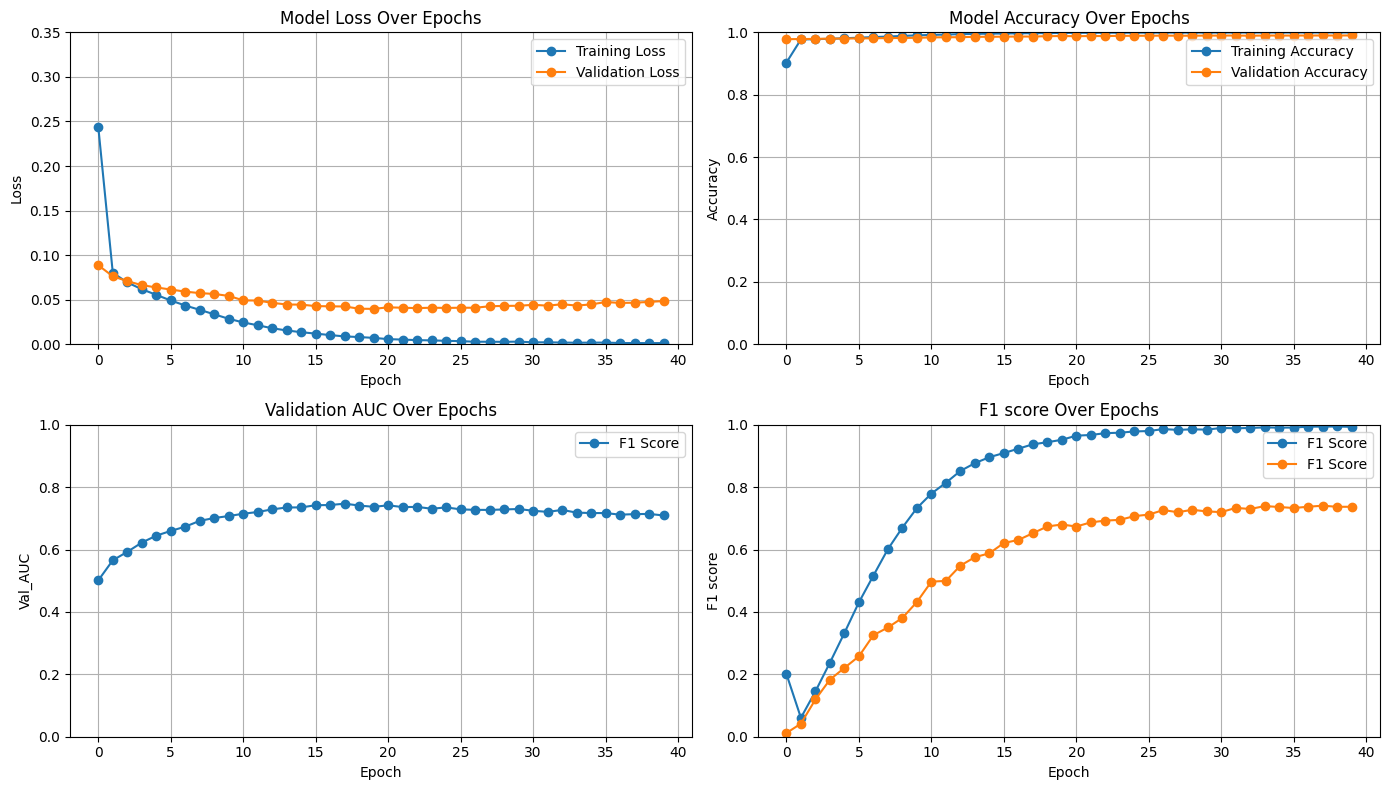

In [29]:
# Plot training & validation loss values
plt.figure(figsize=(14, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.ylim(0,0.35)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.ylim(0,1)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC Plot
plt.subplot(2, 2, 3)
plt.ylim(0,1)
plt.plot(history.history['val_auc'], label='F1 Score', marker='o')
plt.title('Validation AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Val_AUC')
plt.legend()
plt.grid(True)

# F1 Score Plot
plt.subplot(2, 2, 4)
plt.ylim(0,1)
plt.plot(history.history['f1_score'], label='F1 Score', marker='o')
plt.plot(history.history['val_f1_score'], label='F1 Score', marker='o')
plt.title('F1 score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Calculate Hamming Score

In [14]:
from sklearn.metrics import hamming_loss

# Need to reset the validation dataset pointer to the beginning. That requires re-running the validation set definitions. 
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image.numpy()  # Convert to NumPy array

# Load validation images into NumPy arrays
val_x = np.array([load_and_preprocess_image(path) for path in val_image_paths])

# Convert labels to NumPy arrays
val_y = np.array(val_labels)

# Now, we can collect predictions on the validation data
y_pred_probs = model.predict(val_x)
y_pred = (y_pred_probs >= 0.5).astype(int)
y_true = val_y

# Compute Hamming Score
hamming = hamming_loss(y_true, y_pred)
hamming_score = 1 - hamming
print(f"Validation Hamming Score: {hamming_score:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step
Validation Hamming Score: 0.9904


### Make predictions. Adjust prediction threshold value as needed. 

In [21]:
threshold = 0.35   # Adjust as necessary

def predict_ingredients(model, image_path, ingredient_to_index, threshold=threshold):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    image = tf.expand_dims(image, 0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(image)[0]

    # Get predicted ingredients based on the threshold
    predicted_indices = [i for i, p in enumerate(predictions) if p >= threshold]
    index_to_ingredient = {idx: ingr for ingr, idx in ingredient_to_index.items()}
    predicted_ingredients = [index_to_ingredient[idx] for idx in predicted_indices]
    return predicted_ingredients

# Function to calculate total nutritional information
def calculate_nutrition(predicted_ingredients, ingredient_data):
    total_nutrition = {
        'grams': 0.0,
        'calories': 0.0,
        'fat': 0.0,
        'carb': 0.0,
        'protein': 0.0
    }
    for ingr_name in predicted_ingredients:
        # Find the ingredient data from the metadata
        for dish_id, ingredients in dish_ingredients.items():
            for ingredient in ingredients:
                if ingredient['name'] == ingr_name:
                    total_nutrition['grams'] += ingredient['grams']
                    total_nutrition['calories'] += ingredient['calories']
                    total_nutrition['fat'] += ingredient['fat']
                    total_nutrition['carb'] += ingredient['carb']
                    total_nutrition['protein'] += ingredient['protein']
                    break  # Assuming ingredient names are unique
    return total_nutrition

# Example usage
test_image_path = val_image_paths[1]
predicted_ingredients = predict_ingredients(model, test_image_path, ingredient_to_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


### Predict on the test set.  Use the dropdown selector to select a dish. 

In [22]:
# Read glycemic index data
glycemic_index_df = pd.read_excel('glycemic_index.xlsx')

# Create a dictionary mapping from ingredient to glycemic index
gi_dict = dict(zip(glycemic_index_df['Item'], glycemic_index_df['Glycemic index']))

In [23]:
def get_ingredients_for_dish(dish_id):
    # Filter the row corresponding to the selected dish
    dish_row = metadata[metadata['dish_id'] == dish_id]
    if dish_row.empty:
        print(f"No data found for dish_id: {dish_id}")
        return []
    
    dish_row = dish_row.iloc[0]
    
    # Find all ingredient columns
    ingredient_columns = [col for col in metadata.columns if 'ingr_' in col]
    # Get unique n values
    n_values = set()
    for col in ingredient_columns:
        parts = col.split('_')
        if len(parts) >= 3:
            n = parts[1]
            n_values.add(n)
    
    ingredients = []
    for n in n_values:
        ingr_name_col = f'ingr_{n}_name'
        ingr_grams_col = f'ingr_{n}_grams'
        ingr_carb_col = f'ingr_{n}_carb'
        
        # Check if the ingredient name exists
        ingredient_name = dish_row.get(ingr_name_col)
        if pd.notnull(ingredient_name):
            # Get the mass and carbohydrate content per 100g
            mass = dish_row.get(ingr_grams_col, 0)
            carb_per_100g = dish_row.get(ingr_carb_col, 0)
            # Add the ingredient data to the list
            ingredients.append({
                'name': ingredient_name,
                'mass': mass,
                'carb_per_100g': carb_per_100g
            })
    return ingredients

In [24]:
def get_total_nutritional_info(dish_id):
    # Filter the row corresponding to the selected dish
    dish_row = metadata[metadata['dish_id'] == dish_id]
    if dish_row.empty:
        print(f"No data found for dish_id: {dish_id}")
        return None  # or you can return zeros
    
    dish_row = dish_row.iloc[0]
    
    total_info = {
        'total_mass': dish_row.get('total_mass', 0),
        'total_calories': dish_row.get('total_calories', 0),
        'total_fat': dish_row.get('total_fat', 0),
        'total_carb': dish_row.get('total_carb', 0),
        'total_protein': dish_row.get('total_protein', 0)
    }
    return total_info

In [25]:
def calculate_glycemic_index_and_load(ingredients):
    total_mass = 0
    weighted_gi_sum = 0
    total_carb = 0
    missing_ingredients = []
    
    for ingredient in ingredients:
        name = ingredient['name']
        mass = ingredient['mass']
        carb_per_100g = ingredient['carb_per_100g']
        gi = gi_dict.get(name)
        
        if gi is None:
            missing_ingredients.append(name)
            gi = 0  # Use 0 if GI is missing
        
        # Ensure mass and carb_per_100g are numbers
        mass = float(mass) if pd.notnull(mass) else 0
        carb_per_100g = float(carb_per_100g) if pd.notnull(carb_per_100g) else 0
        
        carb_content = mass * (carb_per_100g / 100)
        
        total_mass += mass
        total_carb += carb_content
        weighted_gi_sum += gi * mass
        
    if total_mass > 0:
        gi_dish = weighted_gi_sum / total_mass
    else:
        gi_dish = 0  # Handle case where total_mass == 0
    
    # Glycemic Load calculation
    gl_dish = (total_carb * gi_dish) / 100
    
    if missing_ingredients:
        print(f"Warning: Missing GI data for ingredients: {', '.join(missing_ingredients)}. GI set to 0 for these ingredients.")
    
    return gi_dish, gl_dish

In [26]:
from IPython.display import display, Image, clear_output
import ipywidgets as widgets

# Create a mapping of dish_id to image_path in the validation set
val_dish_ids = [item['dish_id'] for item in val_data]
val_image_paths = [item['image_path'] for item in val_data]
dish_id_to_image_path = dict(zip(val_dish_ids, val_image_paths))

# Create the dropdown widget with dish_ids
dropdown = widgets.Dropdown(
    options=val_dish_ids,
    description='Dish ID:',
    disabled=False,
)

# Create an Output widget to capture and display outputs
output = widgets.Output()

# Define the event handler for the dropdown widget
def on_dropdown_change(change):
    dish_id = change['new']  # Extract the dish_id
    with output:
        output.clear_output()
        
        print(f"Dish ID: {dish_id}")
        
        # Display the dish image
        image_path = dish_id_to_image_path.get(dish_id)
        if image_path:
            display(Image(filename=image_path))
        else:
            print("No image available for this dish.")

        # Predict ingredients
        predicted_ingredients = predict_ingredients(model, image_path, ingredient_to_index)
        print(f"\nPredicted ingredients:\n{predicted_ingredients}", "\n")
            
        # Get total nutritional information
        total_info = get_total_nutritional_info(dish_id)
        if total_info is None:
            print("No nutritional information found for the selected dish.")
            return
        
        # Retrieve the ingredients for the selected dish
        ingredients = get_ingredients_for_dish(dish_id)
        if not ingredients:
            print("No ingredients found for the selected dish.")
            return
        
        # Calculate GI and GL
        gi_dish, gl_dish = calculate_glycemic_index_and_load(ingredients)
        
        # Display the results
        print(f"Total Mass (grams): {total_info['total_mass']}")
        print(f"Total Calories: {total_info['total_calories']}")
        print(f"Total Fat: {total_info['total_fat']} grams")
        print(f"Total Carbohydrates: {total_info['total_carb']} grams")
        print(f"Total Protein: {total_info['total_protein']} grams")
        print()
        print(f"Glycemic Index of the dish: {gi_dish:.2f}")
        print(f"Glycemic Load of the dish: {gl_dish:.2f}")
        print("\n")
            
# Attach the event handler to the dropdown widget
dropdown.observe(on_dropdown_change, names='value')

# Display the dropdown widget and output together using VBox
ui = widgets.VBox([dropdown, output])
display(ui)

# Manually trigger the handler to display initial information
if dropdown.value is not None:
    on_dropdown_change({'new': dropdown.value})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step